# Hyperspectral data analysis

In [1]:
import spectral.io.envi as envi
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import os
import cv2
import pandas as pd

from ipywidgets import interact
from ipywidgets import FloatSlider
from spectral import kmeans
from collections import defaultdict

os.environ["SPECTRAL_DATA"] = "C:\\Users\\ext-lugo\\Hyperspectral\\Radiance"

## A """"simple"""", preliminary analysis

Since hyperspectral images have a lot of bands, for easing analysis, the cells below implement a simple slider to select which band to display

In [14]:
def show_pole(pole_id, rotation_idx):
    paths = os.listdir(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", pole_id))
    paths = [path for path in paths if "float32.hdr" in path]
    paths.sort()
    img = envi.open(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", pole_id, paths[rotation_idx])).load()
    mask = cv2.imread(os.path.join("../../Hyperspectral_masks/", f"{str(pole_id)}_{str(rotation_idx)}_mask.jpg"))
    wls = np.asarray(img.metadata['wavelength'], float)
    img_show = np.where(mask[:,:,0] > 0, np.transpose(img, [2,0,1]), 0)
    img_show = np.transpose(img_show, [1,2,0])
    
    def browse_images(img):
        bands = img.shape[-1]
        def view_images(i=60):
            img_show = np.where(mask[:,:,0] > 0, np.squeeze(img[:,:,i]), 0)
            plt.imshow(img_show, cmap='gray')
            plt.title(f'{wls[i]} nm')
            plt.xticks([])
            plt.yticks([])
        interact(view_images, i=(0, bands - 1))

    browse_images(img_show)

show_pole('0', 0)

interactive(children=(IntSlider(value=60, description='i', max=99), Output()), _dom_classes=('widget-interact'…

In [ ]:
def show_pole_with_reflectance(pole_id, rotation_idx):
    paths = os.listdir(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", pole_id))
    paths = [path for path in paths if "float32.hdr" in path]
    paths.sort()
    img = envi.open(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", pole_id, paths[rotation_idx])).load()
    wls = np.asarray(img.metadata['wavelength'], float)
    
    def browse_images(img):
        bands = img.shape[-1]
        def view_images(i=60):
            plt.imshow(img[:,:,i], cmap='gray', interpolation='nearest')
            plt.title(f'{wls[i]} nm')
            plt.show()
        interact(view_images, i=(0, bands - 1))

    browse_images(img)

In [ ]:
def show_pole_false_color(pole_id, rotation_idx):
    paths = os.listdir(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", pole_id))
    paths = [path for path in paths if "float32.hdr" in path]
    paths.sort()
    img_ro = envi.open(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", pole_id, paths[rotation_idx])).load()
    img = img_ro / np.max(img_ro, axis=(0,1))
    wls = np.asarray(img_ro.metadata['wavelength'], float)
    
    def browse_images(img):
        bands = img.shape[-1]
        def view_images(c1=83, c2=88, c3=11):
            plt.imshow(np.take(img, [c1, c2, c3], axis=2), cmap='gray', interpolation='nearest')
            plt.show()
        interact(view_images, c1=(0, bands - 1), c2=(0, bands - 1), c3=(0, bands - 1))

    browse_images(img)

show_pole_false_color('0', 0)

## Even simpler pole isolation approaches

By taking a look at all the different poles in different rotations, it is possible to see that, for some poles, there seem to be measurement errors at some hyperspectral bands, specially at the intermediate bands.

Due to the nature of the hyperspectral data, it is difficult to isolate the pole from the background. Looking at all the different poles, it can be seen that it is extremely difficult to set thresholds that will work for all different poles. Therefore, more advanced hyperspectral edge detection algorithms are required. Only some simple, already implemented ones will be tried; if these don't work, the images will be manually cropped for now.

The cell below implements the first tries at isolating the pole via thresholds in various channels.

### Naïve attempts: thresholds

In [10]:
def filter_pole_by_bands(pole_id, rotation_idx):
    paths = os.listdir(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", pole_id))
    paths = [path for path in paths if "float32.hdr" in path]
    paths.sort()
    img_ro = envi.open(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", pole_id, paths[rotation_idx])).load()
    img = img_ro / np.max(img_ro, axis=(0,1))
    img = img[:,:850]
    wls = np.asarray(img_ro.metadata['wavelength'], float)
    
    def browse_images(img):
        bands = img.shape[-1]
        def view_images(threshold_1 = 0.15, threshold_2 = 0.9, nir_low_threshold = 0.10, root = 2):
            first_mask = np.expand_dims(np.where((img[:,:,11] > threshold_1) & (img[:,:,90] < threshold_2), 0, 1), axis=2)
            second_mask = np.expand_dims(np.where(img[:,:,-1] < nir_low_threshold, 0, 1), axis=2)
            second_mask[:,150:] = 1
            mask = first_mask & second_mask
            img_new = np.power(img, 1/root)
            img_new /= np.max(img_new, axis=(0,1))
            img_new = img_new * mask
            img_new = np.where(img_new == 0, 1, img_new)
            plt.imshow(np.take(img_new, [-1], axis=2), cmap='gray', interpolation='nearest')
            plt.show()
        interact(view_images, threshold_1=(0.0, 1.0, 0.01), threshold_2=(0.0, 1.0, 0.01), nir_low_threshold=(0.0, 1.0, 0.01), root=(0,10, 0.1))

    browse_images(img)

filter_pole_by_bands('0', 1)

interactive(children=(FloatSlider(value=0.15, description='threshold_1', max=1.0, step=0.01), FloatSlider(valu…

In [124]:
def keep_largest_mask_component(mask):
    mask = mask.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    return img2

def mask_contours(pole_id, rotation_idx, draw=True):
    paths = os.listdir(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id)))
    paths = [path for path in paths if "float32.hdr" in path]
    paths.sort()
    ro_img = envi.open(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id), paths[rotation_idx])).load()
    img = ro_img / np.max(ro_img, axis=(0,1))
    nir_band = (img[:,:,-1] * 255).astype(np.uint8)
    nir_band = cv2.convertScaleAbs(nir_band, 3, 3)
    nir_band[:,825:] = 0
    ret, thresh = cv2.threshold(nir_band, 240, 255, cv2.THRESH_TOZERO_INV)
    ret, thresh = cv2.threshold(thresh, 75, 255, cv2.THRESH_TOZERO)
    plt.imshow(thresh, cmap='gray')
    return
    
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=len)
    contours = [contours[-1]]
    
    mask = np.zeros_like(nir_band)
    cv2.drawContours(mask, contours, -1, 255, -1)
    mask = keep_largest_mask_component(mask)
    mask = np.repeat(mask[...,np.newaxis], img.shape[-1], axis=2)
    out = np.zeros_like(img)
    out[mask == 255] = img[mask == 255]

    if draw:
        plt.figure(figsize = (9, 12))
        plt.imshow(out[:,:,-1])
    
    else:
        return out, mask

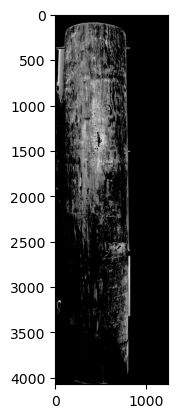

In [128]:
mask_contours(0, 3, draw=True)

### Advanced attempts: algorithms

spectral:INFO: k-means iteration 1 - 4206620 pixels reassigned.
spectral:INFO: k-means iteration 2 - 645274 pixels reassigned.
spectral:INFO: k-means iteration 3 - 396709 pixels reassigned.
spectral:INFO: k-means iteration 4 - 253466 pixels reassigned.
spectral:INFO: k-means iteration 5 - 244923 pixels reassigned.
spectral:INFO: k-means iteration 6 - 168138 pixels reassigned.
spectral:INFO: k-means iteration 7 - 102723 pixels reassigned.
spectral:INFO: k-means iteration 8 - 68866 pixels reassigned.
spectral:INFO: k-means iteration 9 - 46376 pixels reassigned.
spectral:INFO: k-means iteration 10 - 33515 pixels reassigned.
spectral:INFO: k-means iteration 11 - 24837 pixels reassigned.
spectral:INFO: k-means iteration 12 - 18557 pixels reassigned.


KeyboardInterrupt: Returning clusters from previous iteration.


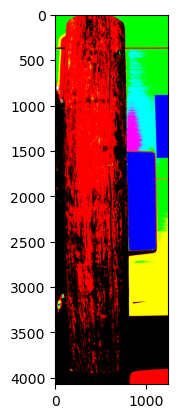

In [14]:
def segment_pole_kmeans(pole_id, rotation_idx):
    paths = os.listdir(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id)))
    paths = [path for path in paths if "float32.hdr" in path]
    paths.sort()
    ro_img = envi.open(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id), paths[rotation_idx])).load()
    
    (m, c) = kmeans(ro_img, 8, 30)
    
    palette = np.array([[  0,   0,   0],
                        [255,   0,   0],
                        [255, 255,   0],
                        [  0, 255,   0],
                        [  0, 255, 255],
                        [  0,   0, 255],
                        [255,   0, 255],
                        [255, 255, 255]])
    
    result = palette[m]
    plt.imshow(result)

segment_pole_kmeans(0, 0)

As it can be seen, a k-means clustering algorithm can detect the pole up to some extent. More algorithms could be tried, but for the sake of keeping the analysis focused on distinguishing different kinds of poles, these will be manually extracted for now

In [4]:
def crop_pole(pole_id, rotation_idx, draw=False, crop=True):
    paths = os.listdir(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id)))
    paths = [path for path in paths if "float32.hdr" in path]
    paths.sort()
    ro_img = envi.open(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id), paths[rotation_idx])).load()
    wls = np.asarray(ro_img.metadata['wavelength'], float)
    
    img = ro_img[150:3900,100:820,:] if crop else ro_img
    white = ro_img[1800:2200,1000:1100,:]
    if draw:
        plt.imshow(img[...,-1], cmap='gray')
    else:
        return img, wls, white

(400, 100, 100)


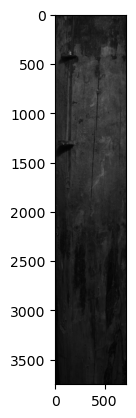

In [104]:
crop_pole(41, 3, draw=True)

## Spectrum analysis

In order to be able to properly characterize the wooden poles, a good starting point is to measure how the wood spectrum changes along the hyperspectral bands. Poles in different conditions are expected to show different spectrums.

Note that, in these plots, no information regarding the rotations is given, as each pole's scans are only labeled with numbers from 1 to 4, instead of the rotation degrees. The rotation could be given by comparing the scans with the RGB photos, but to keep the analysis simple, this will be omitted for now.

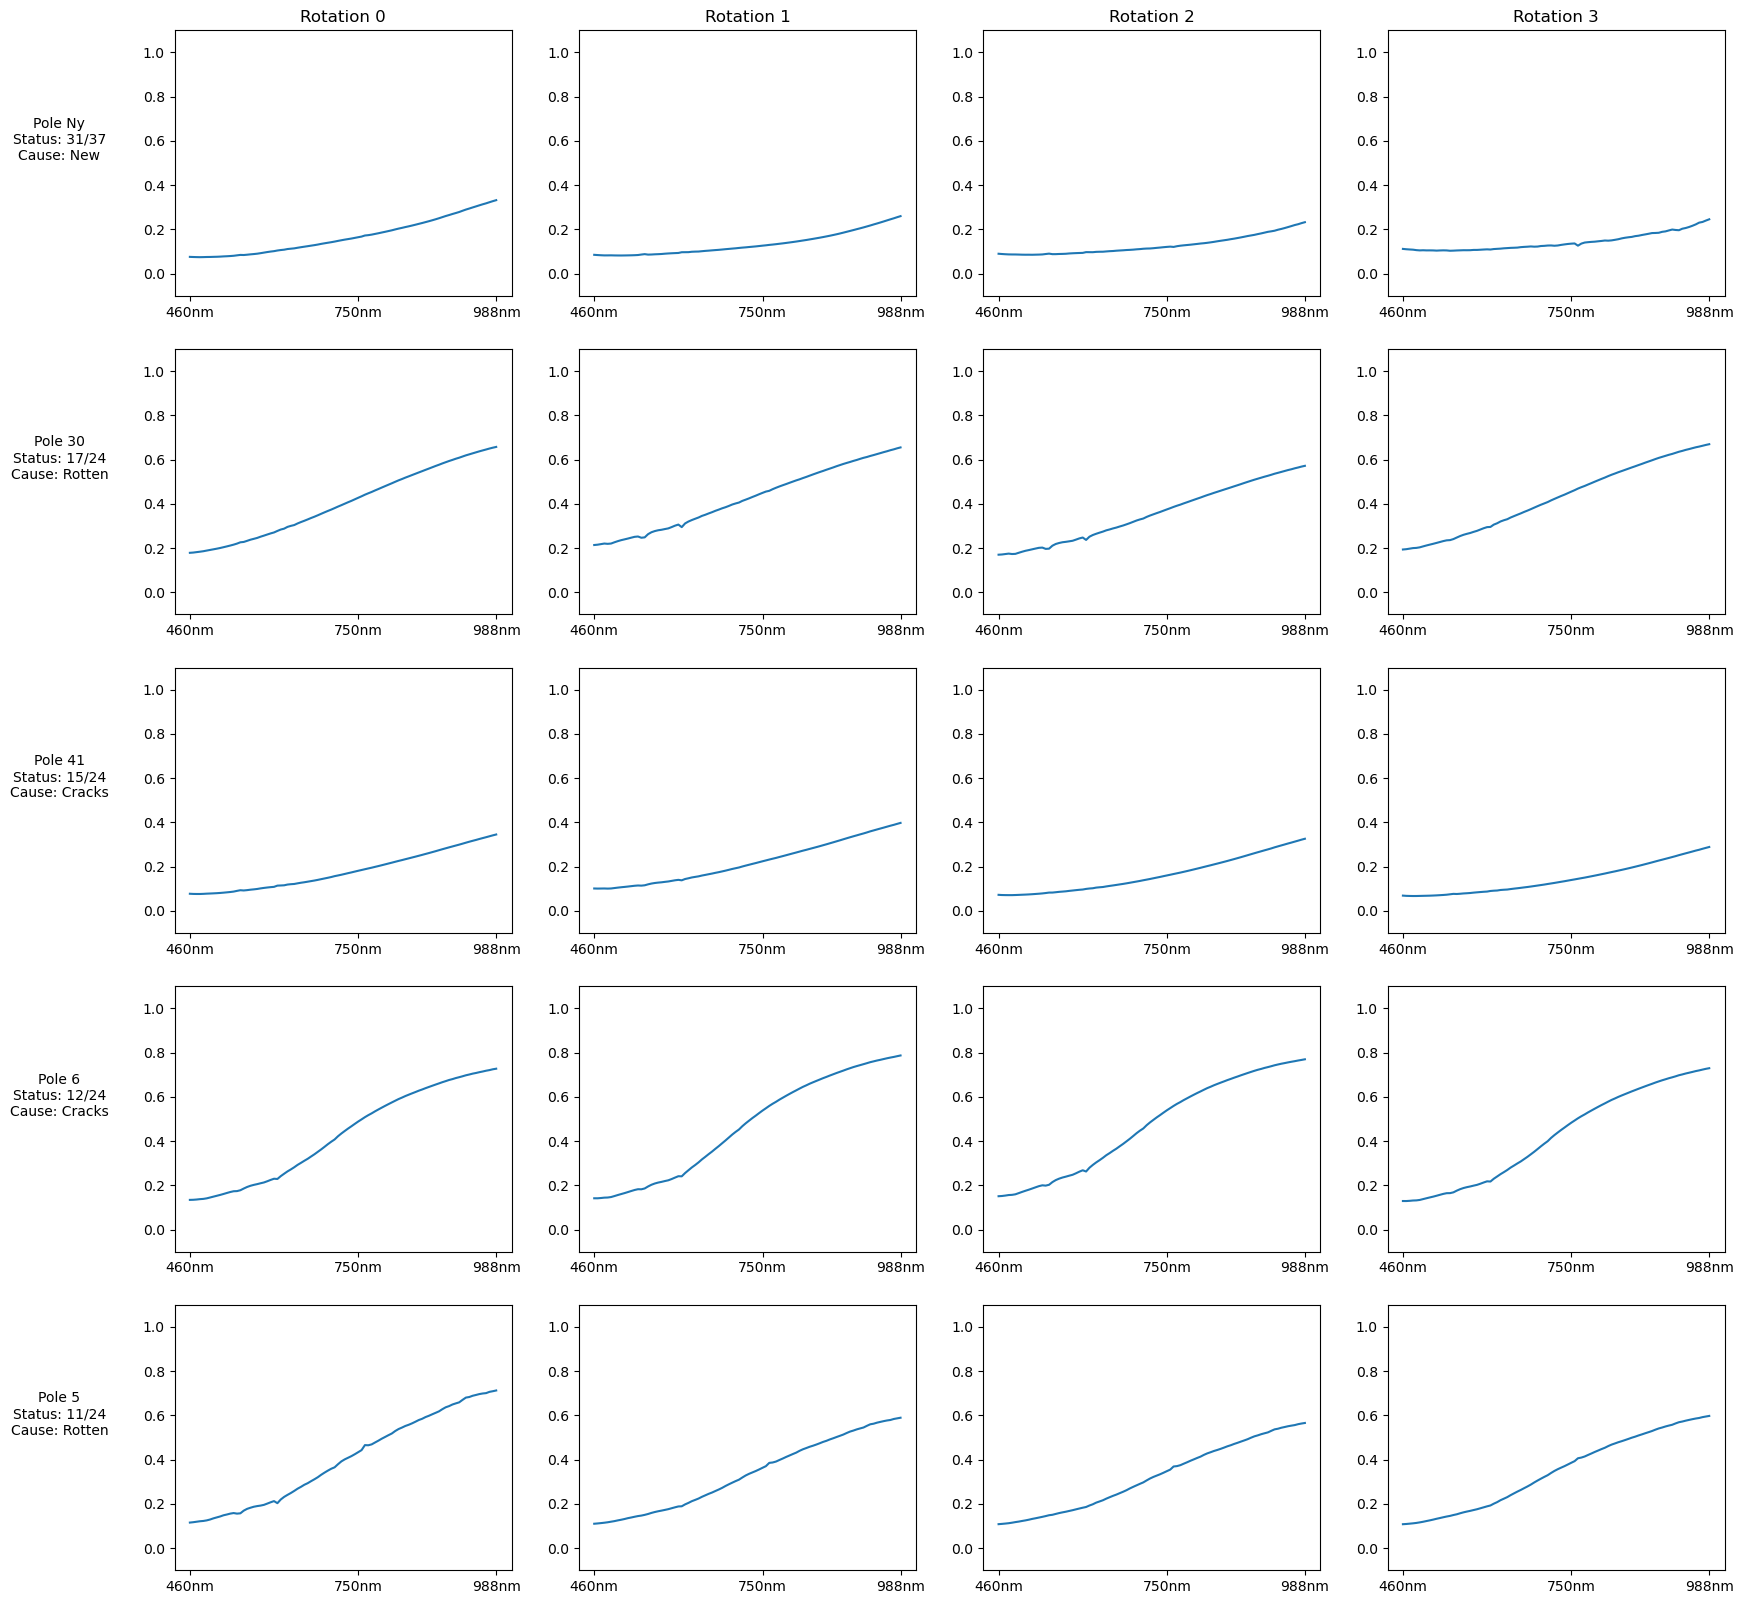

In [5]:
def plot_average_spectra_per_pole_and_rotation(reflectance=True):
    pole_ids = [0,30,41,6,5]
    rotation_idxs = [0,1,2,3]
    wavelength_idxs = [0, 50, 91]
    
    pole_ids_text = ['Ny',30,41,6,5]
    pole_status = ['31/37', '17/24', '15/24', '12/24', '11/24']
    specific_status = ['New', 'Rotten', 'Cracks', 'Cracks', 'Rotten']
    
    data = defaultdict(list)
    data['id'] = [0,30,41,6,5]
    
    fig, axes = plt.subplots(5, 4, figsize=(20,20))
    
    for pole_idx, pole in enumerate(pole_ids):
        for rotation in rotation_idxs:
            cropped_pole, wavelengths, white = crop_pole(pole, rotation)
            # Remove first bands due to noise
            wavelengths = wavelengths[8:]
            cropped_pole = cropped_pole[...,8:]
            white = white[...,8:]
            white_spectrum = np.average(white, axis=(0,1))
            spectrum = np.average(cropped_pole, axis=(0,1))
            
            if reflectance:
                spectrum = spectrum / white_spectrum
                            
            axes[pole_idx, rotation].plot(range(len(spectrum)), spectrum)
            axes[pole_idx, rotation].set_ylim((-0.1, 1.1))
            axes[pole_idx, rotation].set_xticks(wavelength_idxs, [f'{wavelengths[idx]:.0f}nm' for idx in wavelength_idxs])
            
            for band_idx, band_reflectance in enumerate(spectrum):
                data[f'reflectance_band_{band_idx}_{rotation}'].append(band_reflectance)
            
    [axes[0,i].set_title(f'Rotation {i}') for i in range(4)]

    [axes[i,0].set_ylabel(f'Pole {pole}\nStatus: {pole_status[i]}\nCause: {specific_status[i]}', labelpad=60, fontdict={'rotation':0}) for i, pole in enumerate(pole_ids_text)]
    
    plt.savefig(f'hyperspectral_results_per_pole_and_rotation_{"ref" if reflectance else "noref"}.png')
    
    return data
            
data = plot_average_spectra_per_pole_and_rotation(True)
df_spectra = pd.DataFrame(data)
df_spectra.to_csv(f'../Features/hyperspectral.csv')
#plot_average_spectra_per_pole_and_rotation(False)

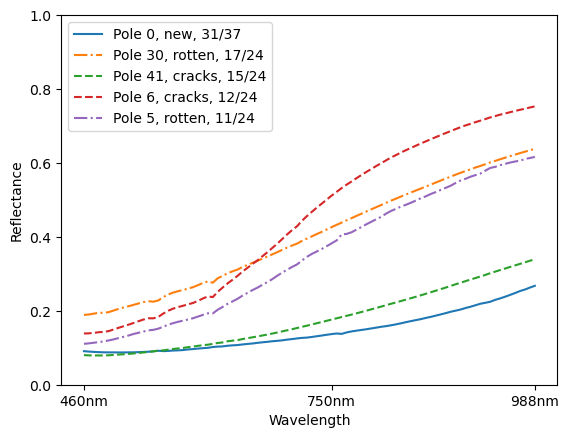

In [134]:
def plot_average_spectra():
    pole_ids = [0,30,41,6,5]
    rotation_idxs = [0,1,2,3]
    wavelength_idxs = [0, 50, 91]
    labels = [
        'Pole 0, new, 31/37',
        'Pole 30, rotten, 17/24',
        'Pole 41, cracks, 15/24',
        'Pole 6, cracks, 12/24',
        'Pole 5, rotten, 11/24',
    ]
    lines = ['-', '-.', '--', '--', '-.']
    
    for pole_idx, pole in enumerate(pole_ids):
        rotation_spectra = []
        for rotation in rotation_idxs:
            cropped_pole, wavelengths, white = crop_pole(pole, rotation)
            # Remove first bands due to noise
            wavelengths = wavelengths[8:]
            cropped_pole = cropped_pole[...,8:]
            white = white[...,8:]
            white_spectrum = np.average(white, axis=(0,1))
            spectrum = np.average(cropped_pole, axis=(0,1))
            rotation_spectra.append(spectrum / white_spectrum)
        avg_spectrum = np.average(rotation_spectra, axis=0)
        plt.plot(range(len(avg_spectrum)), avg_spectrum, linestyle=lines[pole_idx], label=labels[pole_idx])
    plt.ylim((0, 1.0))
    plt.xticks(wavelength_idxs, [f'{wavelengths[idx]:.0f}nm' for idx in wavelength_idxs])
    plt.xlabel('Wavelength')
    plt.ylabel('Reflectance')
    plt.legend()
    plt.savefig('hyperspectral_results.png')
            
plot_average_spectra()

## Hyperspectral data - Outlier analysis

As it was shown in the widgets above, there are some bands for some pole-rotation pairs that appear to be almost completely dark. However, by examining the values present in these, one can see that these are non-zero, and there are also extremely high values. This leads to thinking that there could be outliers that are obscuring the poles in these bands, perhaps due to misreadings in the sensor.

It is therefore a good idea to do a simple analysis to look for outliers. The plots are shown on log scale, since plotting them on a regular scale hides useful information

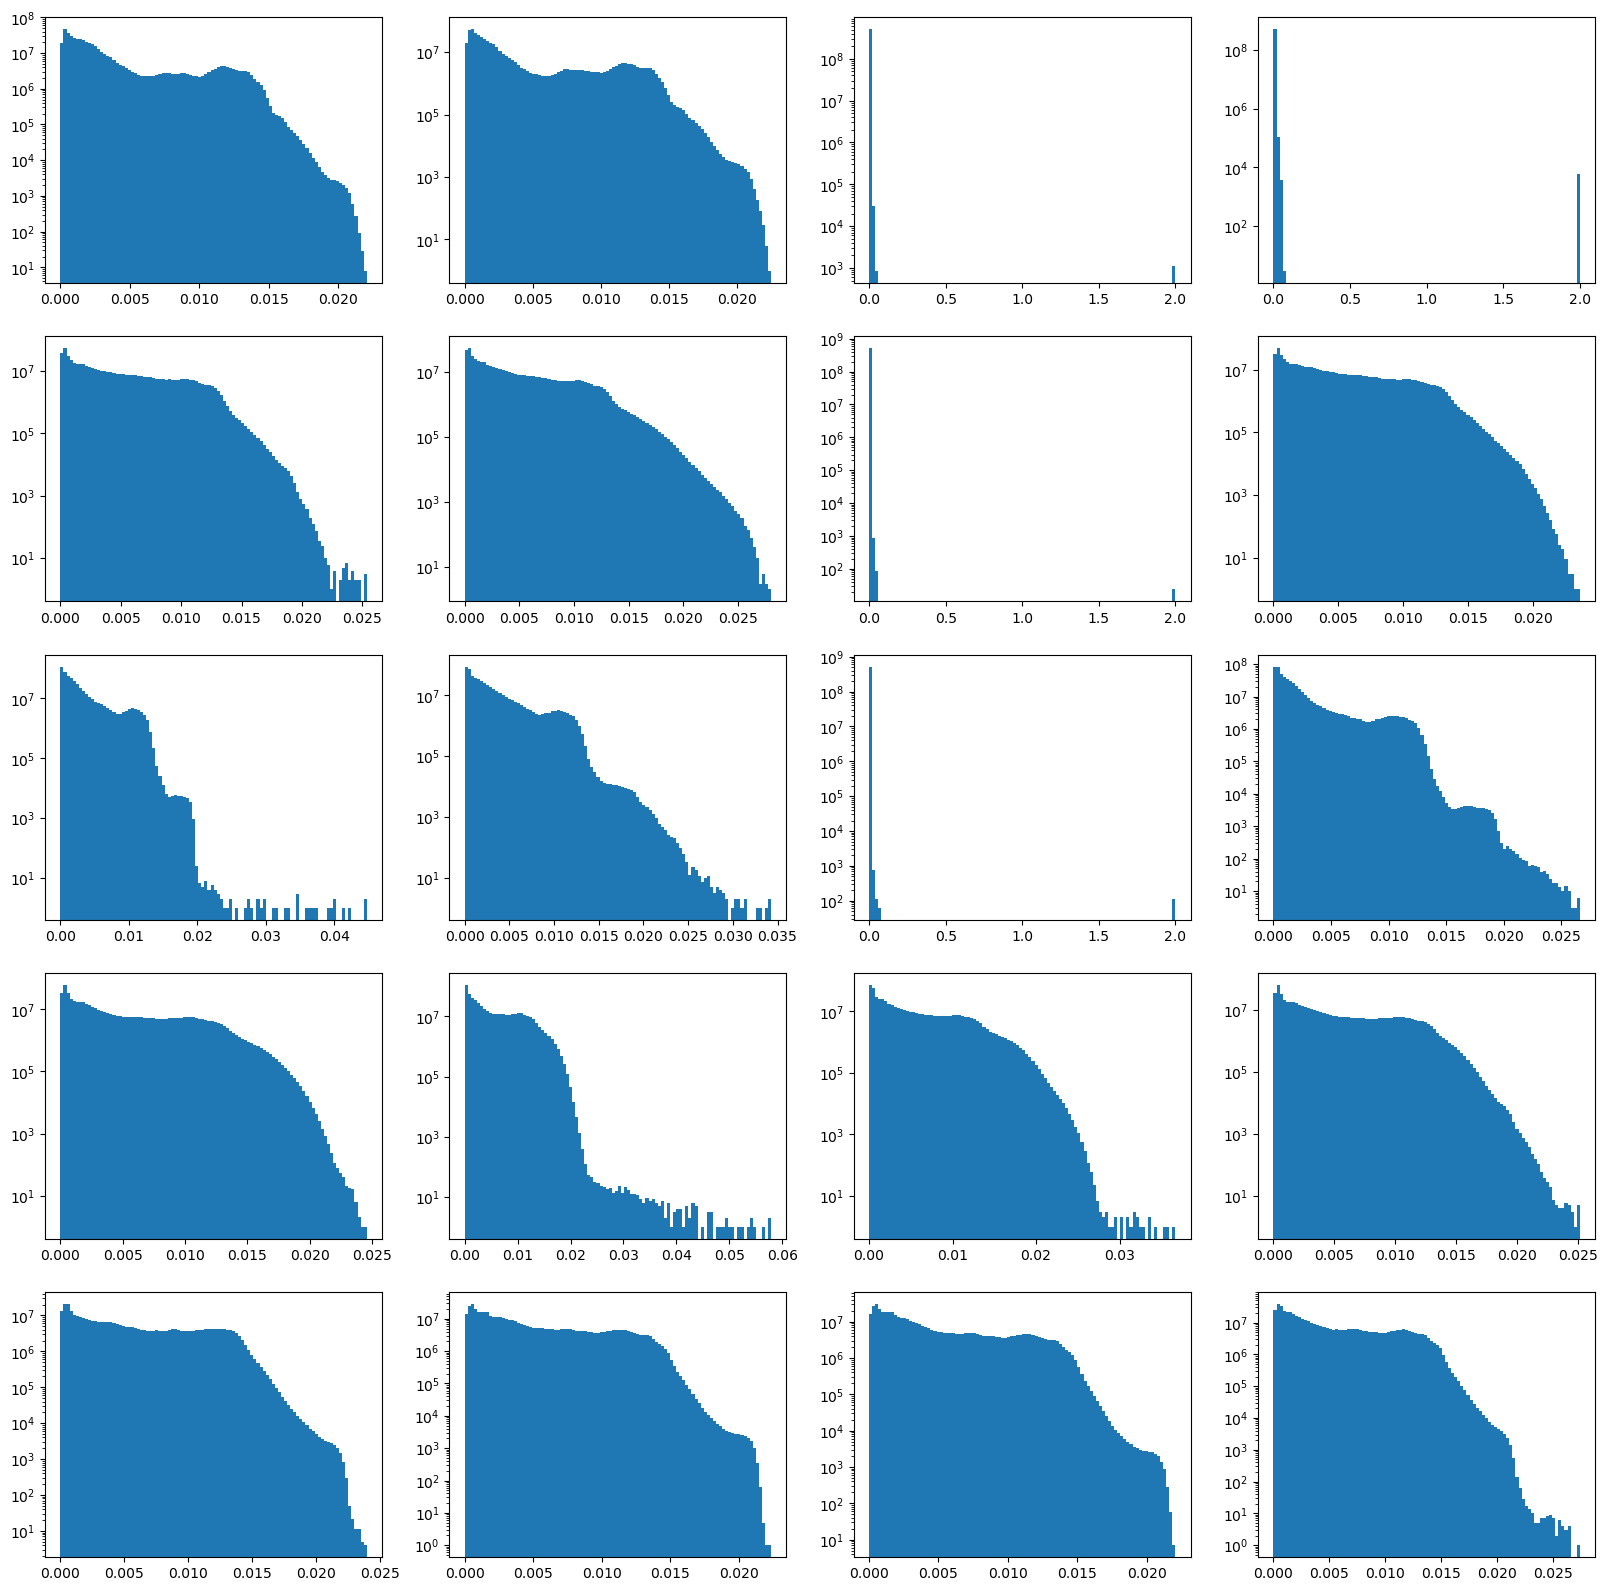

In [6]:
def visualize_outliers():
    fig, axes = plt.subplots(5, 4, figsize=(20,20))
    pole_ids = [0, 30, 41, 6, 5]
    rotation_idxs = [0, 1, 2, 3]
    
    for pole_idx, pole_id in enumerate(pole_ids):
        for rotation_idx in rotation_idxs:
            pole, _, _ = get_pole(pole_id, rotation_idx, crop=False)
            pole = pole.flatten()
            axes[pole_idx,rotation_idx].hist(pole, bins=100, log=True)
            del pole
            
    plt.savefig('../Figures/hyperspectral_histograms.png')
            
visualize_outliers()

From what can be seen on these graphs, poles with normal scans have radiance values between 0 and 0.025 approximately. However, for the scans with black bands, there are extreme values of 2.0. The meaning of this value is unknown, it could be a default value for missing data, or a reading that got out of range. One way or another, values greater than 0.025 will be turned to 0. As these plots show, there are very few values on each scan that exceed 0.025, so this is a good threshold.

The widget below shows the result of plotting the hyperspectral bands, performing this pruning

In [14]:
def show_pole_pruned(pole_id, rotation_idx):
    paths = os.listdir(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", pole_id))
    paths = [path for path in paths if "float32.hdr" in path]
    paths.sort()
    img = envi.open(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", pole_id, paths[rotation_idx])).load()
    wls = np.asarray(img.metadata['wavelength'], float)
    
    def browse_images(img):
        bands = img.shape[-1]
        def view_images(i=60):
            img_clean = np.where(img[:,:,i] > 0.025, 0, img[:,:,i])
            plt.imshow(img_clean, cmap='gray', interpolation='nearest')
            plt.title(f'{wls[i]} nm')
            plt.show()
        interact(view_images, i=(0, bands - 1))

    browse_images(img)

show_pole_pruned('0', 0)

interactive(children=(IntSlider(value=60, description='i', max=99), Output()), _dom_classes=('widget-interact'…

Now that these extreme values have been removed, it is possible to see the pole in the scans that appeared to be completely dark, as those values were indeed outliers. However, this should not affect the analysis more than for visualization purposes, but as best practice, these values will always be pruned as before.

In [19]:
def clean_pole(img):
    return np.where(img > 0.025, 0, img)